In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('clarke-default')

### Define some constants

In [37]:
d_ns = 166e-9 # 166 nm, diameter of a nanosphere in meters
r_ns = d_ns/2. # radius of a nanosphere in meters
V_ns = (4/3.)*np.pi*r_ns**3
rho_silica = 2.65e3 # density of silica, kg/m^3
m_ns = rho_silica*V_ns # mass of a nanosphere in kg

k_B = 1.38e-23 # Boltzmann constant in J/K
p_bar = 1e-3#0.2 # pressure in bar
pa_per_bar = 1e5 # Pascal per bar
p_pa = p_bar*pa_per_bar
d_N2 = 364e-12 # diameter of an N2 molecule in meters
T = 293. # temperature in K

d_d = 5e-6 # ethanol droplet diameter in meters

# Cunningham correction factor values
A_1 = 1.257
A_2 = 0.4
A_3 = 0.55

rho_eth = 789 # density of ethanol in kg/m^3
N_Av = 6.022e23 # Avogadro's number

M_N2 = 28.e-3 # molar mass of air in kg/mol
rho_g = M_N2*p_pa/(k_B*N_Av*T)

mu_air = 18.5e-6 # dynamic viscosity of air in Pa.s

g = 9.80 # gravitational field strength in m/s^2

m_N2 = M_N2/N_Av # mass of an N2 molecule in kg
delta = 1.2 # usually 1 to 1.4
cbar = np.sqrt(8*k_B*T/(np.pi*m_N2)) # arithmetic mean speed of the gas species in m/s

H_ch = 0.1 # representative height of the chamber in meters

### Estimate fall time for ethanol droplets

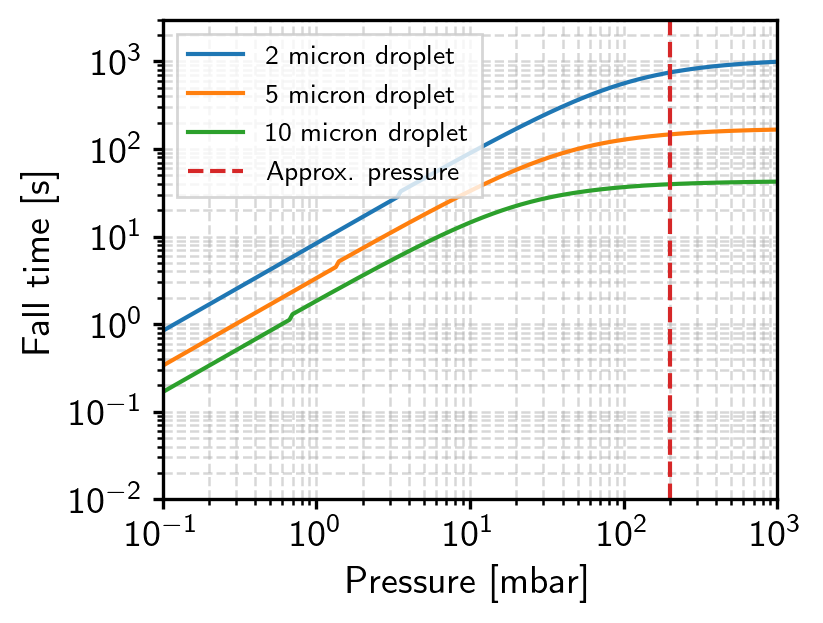

In [42]:
def t_fall(p, d_d=d_d):
    p = np.array(p)
    lam_N2 = k_B*T/(p*np.sqrt(2)*np.pi*d_N2**2)
    Kn = lam_N2/d_d
    v_t = np.zeros(p.shape)
    rho_g = M_N2*p/(k_B*N_Av*T)

    Kn_thresh = 10.

    # Stokes drag regime
    C_c = 1 + 2*lam_N2/d_d*(A_1 + A_2*np.exp(-A_3*d_d/lam_N2))
    v_t[Kn < Kn_thresh] = (rho_eth - rho_g[Kn < Kn_thresh])*g*d_d**2/(18*mu_air)*C_c[Kn < Kn_thresh]

    # Epstein drag regime
    v_t[Kn >= Kn_thresh] = (rho_eth - rho_g[Kn >= Kn_thresh])*g*d_d/(2.*delta*rho_g[Kn >= Kn_thresh]*cbar)

    return H_ch/v_t

p_plot = np.logspace(-4, 0, 200)*pa_per_bar

fig, ax = plt.subplots(figsize=(4, 3), layout='constrained')
ax.loglog(p_plot/pa_per_bar*1e3, t_fall(p_plot, d_d=2e-6), label='2 micron droplet')
ax.loglog(p_plot/pa_per_bar*1e3, t_fall(p_plot), label='{:.0f} micron droplet'.format(d_d*1e6))
ax.loglog(p_plot/pa_per_bar*1e3, t_fall(p_plot, d_d=1e-5), label='10 micron droplet')
# ax.axvspan(p_plot[0]/pa_per_bar*1e3, p_plot[np.argmin(np.diff(t_fall(p_plot)))]/pa_per_bar*1e3, \
#            lw=0, alpha=0.2, color='C1')
# ax.axvspan(p_plot[np.argmin(np.diff(t_fall(p_plot)))]/pa_per_bar*1e3, p_plot[-1]/pa_per_bar*1e3, \
#            lw=0, alpha=0.2, color='C2')
ax.axvline(200, ls='--', color='C3', label='Approx. pressure')
ax.set_xlabel('Pressure [mbar]')
ax.set_ylabel('Fall time [s]')
ax.set_xlim([p_plot[0]/pa_per_bar*1e3, p_plot[-1]/pa_per_bar*1e3])
# ax.set_yticks(np.logspace(-4, 2, 7))
ax.set_ylim([1e-2, 3e3])
ax.grid(which='both')
ax.legend(loc='upper left')

### Estimate activity as a function of nebulization parameters

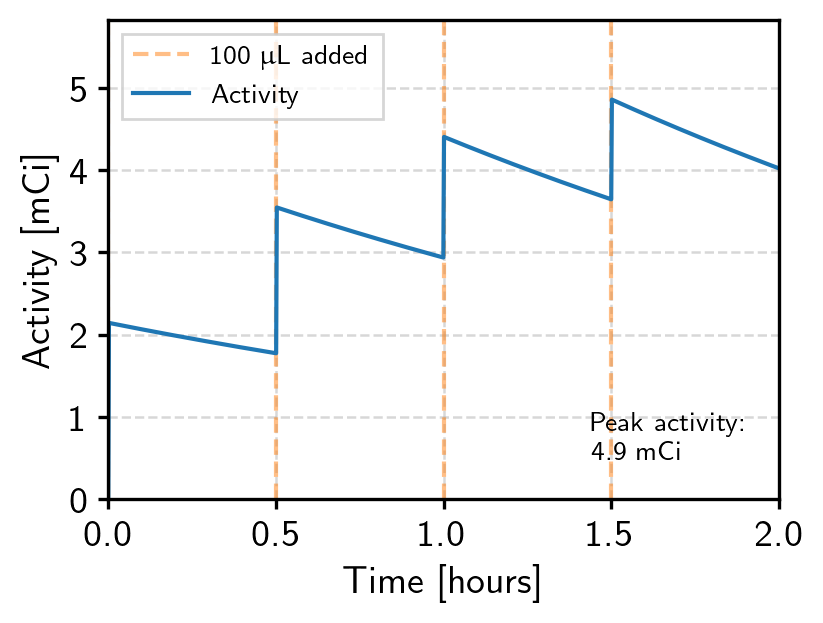

In [45]:
V_eth = 40. # volume of ethanol in mL
M_ns = 3. # mass of nanospheres in mg

conc = M_ns/V_eth # concentration of nanospheres in the ethanol in mg/mL or equivalently kg/m^3
V_neb = 0.1 # 100 uL in mL
N_ns = (M_ns/(m_ns*1e6))*(V_neb/V_eth) # total number of nanospheres nebulized

run_time_hours = 2 # total run time in hours
pump_time_hours = 3 # time data collection starts after pumpdown
meas_time_hours = 10 # total measurement time after pumpdown
neb_period_hours = 0.5 # period of nebulizations in hours
decays_per_sphere = 200 # number of decays during the full measurement interval

tau_F18 = 6586/np.log(2) # F-18 lifetime in seconds
# number of F-18 in each sphere initially
F18_per_sphere = decays_per_sphere/(np.exp(-pump_time_hours*3600/tau_F18) - \
                                    np.exp(-(pump_time_hours + meas_time_hours)*3600/tau_F18))

times = np.linspace(0, run_time_hours, 1000)*3600
dt = np.diff(times)[-1]
neb_period = neb_period_hours*3600

neb_times = np.arange(0, np.amax(times), neb_period)
neb_inds = np.array([np.argmin(np.abs(times - t)) for t in neb_times])
accum_rate = np.zeros_like(times)
accum_rate[neb_inds] = N_ns*F18_per_sphere*np.exp(-times[neb_inds]/tau_F18)/dt

N_of_t = np.zeros_like(times)
dN_by_dt = np.zeros_like

# integrate the differential equation to get the number of F-18 atoms in the chamber vs time
for i in range(1, len(times)):
    N_of_t[i] = N_of_t[i-1] + (-N_of_t[i-1]/tau_F18 + accum_rate[i-1])*dt

# convert to activity
activity_Bq = N_of_t/tau_F18
Bq_per_Ci = 37e9
activity_Ci = activity_Bq/Bq_per_Ci

fig, ax = plt.subplots(figsize=(4, 3), layout='constrained')
ax.vlines(neb_times/3600, 0, 1.2*np.amax(activity_Ci*1e3), ls='--', color='C1', alpha=0.5, label=r'100 $\mu$L added')
ax.plot(times/3600, activity_Ci*1e3, label='Activity')
ax.text(0.72*np.amax(times)/3600, 0.1*np.amax(activity_Ci*1e3), \
        'Peak activity:\n{:.1f} mCi'.format(np.amax(activity_Ci*1e3)), fontsize=10)
ax.set_xlabel('Time [hours]')
ax.set_ylabel('Activity [mCi]')
ax.set_xlim([0, np.amax(times/3600)])
ax.set_ylim([0, 1.2*np.amax(activity_Ci*1e3)])
ax.grid(which='both')
ax.legend(loc='upper left')